<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torchvision.transforms import Lambda, ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



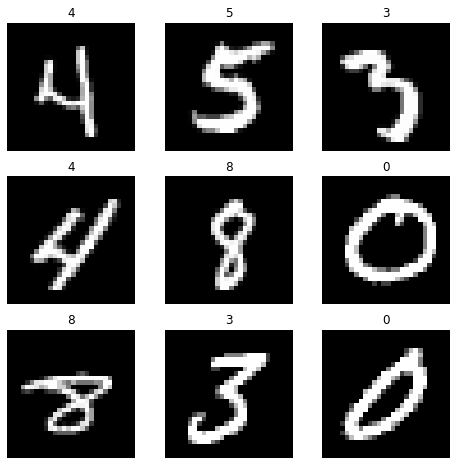

In [3]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


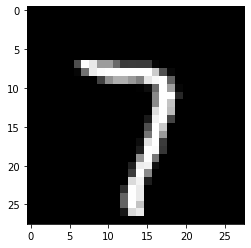

Label: 7


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#print(train_features[0].size())
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [6]:
ds = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
         
        # Linear encoder with ReLu activation
        # 784 ==> 10
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
         
        # Linear decoder with ReLu activation
        # The Sigmoid activation function outputs the value between 0 and 1
        # 10 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 28*28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x).to(device)
        decoded = self.decoder(encoded).to(device)
        return decoded

In [9]:
model = AutoEncoder().to(device)

In [10]:
loss_function = nn.CrossEntropyLoss()

In [11]:
learning_rate = 1e-3
batch_size = 64

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

0
1
2
3
4
5
6
7
8
9


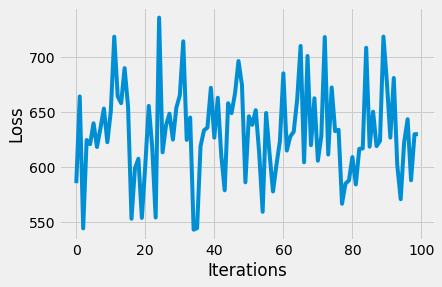

In [18]:
epochs = 10
outputs = []
losses = []
for epoch in range(epochs):
    print(epoch)
    for X, y in train_dataloader:
       
      # Reshaping the image to (-1, 784)
      X = (X.reshape(-1, 28*28)).to(device)
       
      # Output of Autoencoder
      reconstructed = model(X).to(device)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, X)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss.detach().cpu().numpy())
    outputs.append((epochs, X, reconstructed))
 
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])

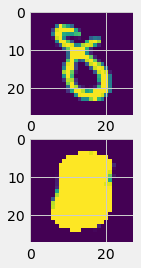

In [19]:
fig, axs = plt.subplots(2)
for i, item in enumerate(X):   
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28).cpu()
  axs[0].imshow(item[0])
 
for i, item in enumerate(reconstructed):
  item = item.reshape(-1, 28, 28).detach().cpu().numpy()
  axs[1].imshow(item[0])